<a href="https://colab.research.google.com/github/OksanaBut77/TFM/blob/main/TFM_farmacias_Cluster_Mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, cdist
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve

In [ ]:
df_member = pd.read_csv('/content/drive/MyDrive/TFM/df_farma_mode.csv')
print(df_member.head(5))

   depart_id  card_id  member_class    last_consume_time  card_type  \
0     270297  1936560           407  2021-09-13 06:18:05          0   
1     270297  3208730          1515  2020-01-22 09:18:15          0   
2     270155  4053650          1700  2021-11-13 09:57:18          0   
3     270155  4053950          1672  2021-12-05 18:49:25          0   
4     270297  4133810           407  2021-09-13 06:18:05          0   

   define_class  is_suff  level    birthday  consume_level  point  \
0           170        0      2  1968-12-01              1    0.0   
1           426        0      2  1954-07-24              1    0.0   
2           578        0      3  2016-09-02              1    0.0   
3           287        0      3  1951-09-13              1    0.0   
4           170        0      2  2015-12-28              1    0.0   

            updatetime  sex   age  Recency  
0  2021-09-13 06:18:05  0.0  53.0        0  
1  2021-09-13 06:18:05  0.0  67.0      599  
2  2021-11-28 05:31:55 

In [ ]:
df_member.shape

(10000, 15)

In [ ]:
df_member.dtypes

,0
depart_id,int64
card_id,object
member_class,int64
last_consume_time,object
card_type,int64
define_class,int64
is_suff,int64
level,int64
birthday,object
consume_level,int64


In [ ]:
df_member.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency'],
      dtype='object')

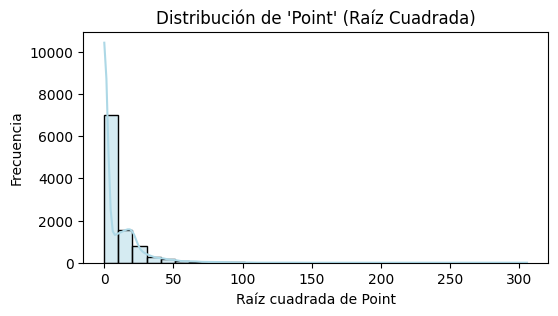

In [ ]:
df_member['point_sqrt'] = np.sqrt(df_member['point'])

plt.figure(figsize=(6, 3))
sns.histplot(df_member['point_sqrt'], bins=30, kde=True, color='lightblue')
plt.xlabel("Raíz cuadrada de Point")
plt.ylabel("Frecuencia")
plt.title("Distribución de 'Point' (Raíz Cuadrada)")
plt.show()

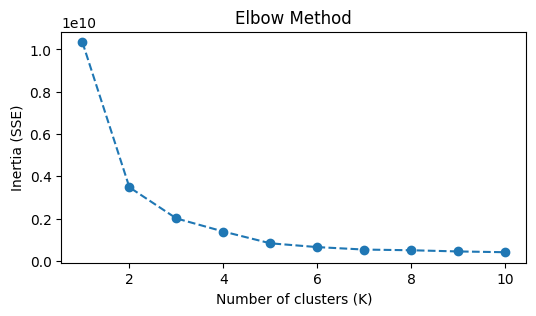

In [ ]:
# Lista para  valores de la inercia (SSE)
inertia = []

#número de clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_member[['member_class', 'card_type',
       'define_class', 'is_suff', 'level', 'consume_level',
       'point_sqrt', 'sex', 'age', 'Recency']])  # columnas para el clustering
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.show()

In [ ]:
# (normalización)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_member[['member_class', 'card_type',
       'define_class', 'is_suff', 'level', 'consume_level',
       'point_sqrt', 'sex', 'age', 'Recency']])


# clustering
clustering_algorithms = {
    "K-Means (3 clusters)": KMeans(n_clusters=3, random_state=42),
    "K-Means (4 clusters)": KMeans(n_clusters=4, random_state=42),
    "Mean-Shift": MeanShift(),
    "Agglomerative Clustering": AgglomerativeClustering(),
    "DBSCAN": DBSCAN(),
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

#  lista métricas
metrics_data = []

# Clustering y evaluación
for name, algorithm in clustering_algorithms.items():
    algorithm.fit(df_normalized)

    # Predicción de etiquetas
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else algorithm.predict(df_normalized)

    # métricas
    sil_score = silhouette_score(df_normalized, labels)
    ch_score = calinski_harabasz_score(df_normalized, labels)
    db_score = davies_bouldin_score(df_normalized, labels)

    # resultados
    metrics_data.append([sil_score, ch_score, db_score])

# DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data, columns=["Silhouette Score", "Calinski-Harabasz", "Davies-Bouldin"],
                          index=clustering_algorithms.keys())

print(metrics_df)

                          Silhouette Score  Calinski-Harabasz  Davies-Bouldin
K-Means (3 clusters)              0.487808        3794.915501        1.347339
K-Means (4 clusters)              0.486470        2882.656371        1.691801
Mean-Shift                        0.542897         582.658198        1.050127
Agglomerative Clustering          0.436540        3664.496863        1.318242
DBSCAN                            0.410044         223.121669        1.306927
GMM                               0.482593        2870.447045        1.396751


In [ ]:
df_member.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency',
       'point_sqrt'],
      dtype='object')

In [ ]:
#df_member=df_member.drop(columns=['Cluster'])

# K-Means

In [ ]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_member['Cluster KMeans'] = kmeans.fit_predict(df_normalized)

print(df_member['Cluster KMeans'].value_counts())

# centroides de los clusters
#print("Centroides:")
#print(kmeans.cluster_centers_)

Cluster KMeans
1    5843
2    2717
0    1440
Name: count, dtype: int64


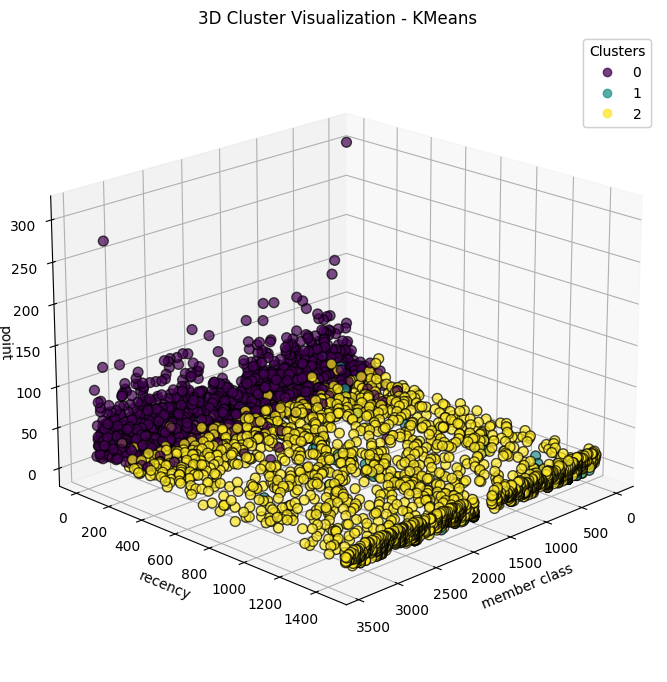

In [ ]:
# Crear figura 3D con mayor espacio
fig = plt.figure(figsize=(8, 8))  # Aumentamos el tamaño de la figura
ax = fig.add_subplot(111, projection='3d')

# Obtener los valores originales para la visualización
x = df_member['member_class']
y = df_member['Recency']
z = df_member['point_sqrt']
clusters = df_member['Cluster KMeans']

# Graficar puntos en 3D
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', edgecolors='k', s=50, alpha=0.7)

# Etiquetas
ax.set_xlabel("member class")
ax.set_ylabel("recency")
ax.set_zlabel("point", labelpad=0)
ax.set_title("3D Cluster Visualization - KMeans")

# Cambiar el ángulo de visualización
ax.view_init(elev=20, azim=45)

# Ajustar los márgenes a la izquierda y derecha
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Leyenda
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="best")
ax.add_artist(legend1)

# Mostrar gráfico
plt.show()

# AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
# Aplicar Agglomerative Clustering (4 clusters por defecto, puedes ajustar n_clusters)
n_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_member['Cluster Agglom'] = agg_clustering.fit_predict(df_normalized)

print(df_member['Cluster Agglom'].value_counts())

Cluster Agglom
1    5616
2    2931
0    1453
Name: count, dtype: int64


In [ ]:
df_member.head()

,depart_id,card_id,member_class,last_consume_time,card_type,define_class,is_suff,level,birthday,consume_level,point,updatetime,sex,age,Recency,point_sqrt,Cluster KMeans,Cluster Agglom
0,270297,1936560,407,2021-09-13 06:18:05,0,170,0,2,1968-12-01,1,0.0,2021-09-13 06:18:05,0.0,53.0,0,0.0,1,1
1,270297,3208730,1515,2020-01-22 09:18:15,0,426,0,2,1954-07-24,1,0.0,2021-09-13 06:18:05,0.0,67.0,599,0.0,1,2
2,270155,4053650,1700,2021-11-13 09:57:18,0,578,0,3,2016-09-02,1,0.0,2021-11-28 05:31:55,1.0,5.0,14,0.0,0,2
3,270155,4053950,1672,2021-12-05 18:49:25,0,287,0,3,1951-09-13,1,0.0,2021-12-14 05:57:15,1.0,70.0,8,0.0,1,2
4,270297,4133810,407,2021-09-13 06:18:05,0,170,0,2,2015-12-28,1,0.0,2021-09-13 06:18:05,0.0,5.0,0,0.0,1,1


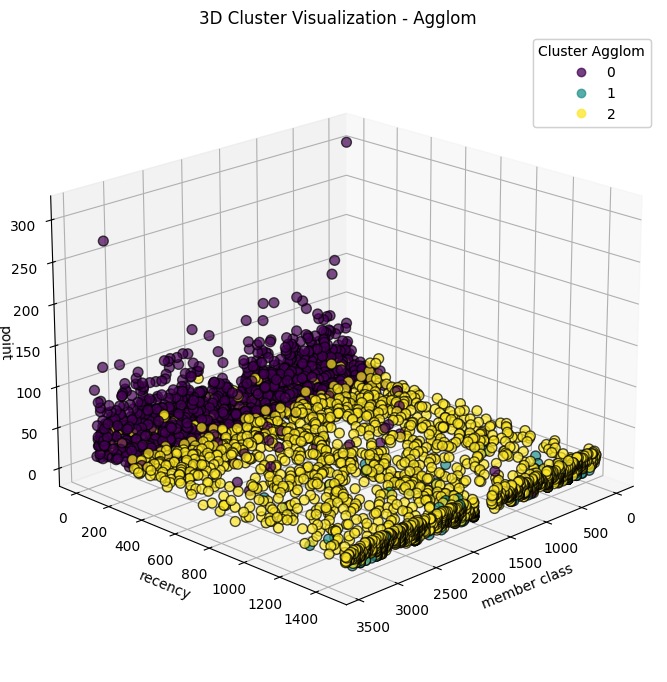

In [ ]:
# Crear figura 3D con mayor espacio
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Obtener los valores originales para la visualización
x = df_member['member_class']
y = df_member['Recency']
z = df_member['point_sqrt']
clusters = df_member['Cluster Agglom']

# Graficar puntos en 3D
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', edgecolors='k', s=50, alpha=0.7)

# Etiquetas
ax.set_xlabel("member class")
ax.set_ylabel("recency")
ax.set_zlabel("point", labelpad=0)
ax.set_title("3D Cluster Visualization - Agglom")

# Cambiar el ángulo de visualización
ax.view_init(elev=20, azim=45)

# Ajustar los márgenes a la izquierda y derecha
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Leyenda
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster Agglom", loc="best")
ax.add_artist(legend1)

# Mostrar gráfico
plt.show()

In [ ]:
#df_member=df_member.drop(columns=['diana_cluster'])

In [ ]:
df_member[['Cluster KMeans', 'Cluster Agglom']].value_counts()

Cluster KMeans  Cluster Agglom
1               1                 5577
2               2                 2541
0               0                 1294
1               2                  244
0               2                  146
2               0                  137
                1                   39
1               0                   22
Name: count, dtype: int64

# Adjusted Rand Index

In [ ]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_member['Cluster KMeans'], df_member['Cluster Agglom'])
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.854


In [ ]:
print(df_member.head())

   depart_id  card_id  member_class    last_consume_time  card_type  \
0     270297  1936560           407  2021-09-13 06:18:05          0   
1     270297  3208730          1515  2020-01-22 09:18:15          0   
2     270155  4053650          1700  2021-11-13 09:57:18          0   
3     270155  4053950          1672  2021-12-05 18:49:25          0   
4     270297  4133810           407  2021-09-13 06:18:05          0   

   define_class  is_suff  level    birthday  consume_level  point  \
0           170        0      2  1968-12-01              1    0.0   
1           426        0      2  1954-07-24              1    0.0   
2           578        0      3  2016-09-02              1    0.0   
3           287        0      3  1951-09-13              1    0.0   
4           170        0      2  2015-12-28              1    0.0   

            updatetime  sex   age  Recency  point_sqrt  Cluster KMeans  \
0  2021-09-13 06:18:05  0.0  53.0        0         0.0               1   
1  2021-09

------------------------
-----------------------

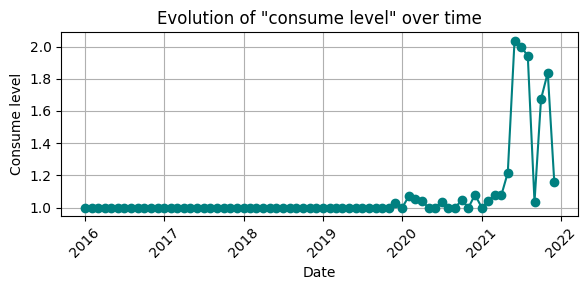

In [ ]:
df_member['last_consume_time'] = pd.to_datetime(df_member['last_consume_time'])

# Ordenar por fecha
df_line = df_member.sort_values(by='last_consume_time')

# Agrupar por fecha (puedes agrupar por día, mes, etc.)
df_grouped = df_line.groupby(df_line['last_consume_time'].dt.to_period('M'))['consume_level'].mean()
df_grouped.index = df_grouped.index.to_timestamp()

# Crear gráfico de líneas
plt.figure(figsize=(6, 3))
plt.plot(df_grouped.index, df_grouped.values, marker='o', color='teal')
plt.title('Evolution of "consume level" over time')
plt.xlabel('Date')
plt.ylabel('Consume level')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

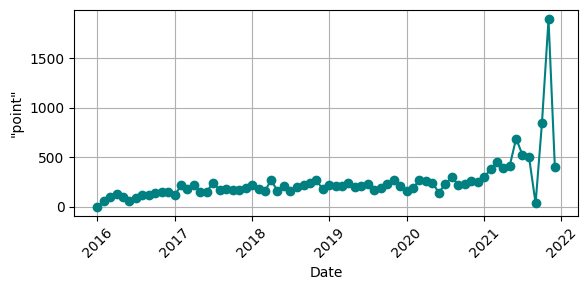

In [ ]:
# Ordenar por fecha
df_line = df_member.sort_values(by='last_consume_time')

# Agrupar por fecha (puedes agrupar por día, mes, etc.)
df_grouped = df_line.groupby(df_line['last_consume_time'].dt.to_period('M'))['point'].mean()
df_grouped.index = df_grouped.index.to_timestamp()

# Crear gráfico de líneas
plt.figure(figsize=(6, 3))
plt.plot(df_grouped.index, df_grouped.values, marker='o', color='teal')
#plt.title('Evolution of the variable "point" over time')
plt.xlabel("Date")
plt.ylabel('"point"')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Si cambian de Cluster o no

In [ ]:
# Convertir la columna a tipo datetime
df_member['last_consume_time'] = pd.to_datetime(df_member['last_consume_time'], errors='coerce')

# Definir la fecha de referencia
reference_date1 = pd.to_datetime('2020-12-14')
reference_date2 = pd.to_datetime('2021-12-14')

# Calcular la recencia
df_member['Recency1'] = (reference_date1 - df_member['last_consume_time']).dt.days
df_member['Recency2'] = (reference_date2 - df_member['last_consume_time']).dt.days

In [ ]:
df_member['Recency1'] = df_member['Recency1'].clip(lower=0)
df_member['Recency2'] = df_member['Recency2'].clip(lower=0)

In [ ]:
# Normalizar con Recency1
scaler = StandardScaler()
features_r1 = ['member_class', 'card_type', 'define_class', 'is_suff', 'level',
               'consume_level', 'point_sqrt', 'sex', 'age', 'Recency1']

X_r1 = scaler.fit_transform(df_member[features_r1])

# KMeans con 3 clusters
kmeans_r1 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_member['Cluster_Recency1'] = kmeans_r1.fit_predict(X_r1)


In [ ]:
# Normalizar con Recency2
features_r2 = features_r1.copy()
features_r2[-1] = 'Recency2'  # Reemplazamos Recency1 por Recency2

X_r2 = scaler.fit_transform(df_member[features_r2])

# KMeans con 3 clusters
kmeans_r2 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_member['Cluster_Recency2'] = kmeans_r2.fit_predict(X_r2)

In [ ]:
(df_member['Cluster_Recency2'] != df_member['Cluster_Recency1']).sum()

np.int64(41)

In [ ]:
(df_member['Cluster KMeans'] != df_member['Cluster_Recency1']).sum()

np.int64(7310)

In [ ]:
(df_member['Cluster KMeans'] != df_member['Cluster_Recency2']).sum()

np.int64(7291)

In [ ]:
pd.crosstab(df_member['Cluster KMeans'], df_member['Cluster_Recency1'])

Cluster_Recency1,0,1,2
Cluster KMeans,,,
0,0,1429,11
1,5771,1,71
2,16,12,2689


In [ ]:
pd.crosstab(df_member['Cluster KMeans'], df_member['Cluster_Recency2'])

Cluster_Recency2,0,1,2
Cluster KMeans,,,
0,0,1427,13
1,5786,0,57
2,8,0,2709


In [ ]:
ari = adjusted_rand_score(df_member['Cluster KMeans'], df_member['Cluster_Recency1'])
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.9658452472307077


In [ ]:
ari = adjusted_rand_score(df_member['Cluster KMeans'], df_member['Cluster_Recency2'])
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.9753075885597495
